##Done by Edward Andres Sandoval Pineda

#Import and install libraries

In [1]:
!pip install yfinance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance
from sklearn.cluster import KMeans
from numpy.lib.stride_tricks import sliding_window_view
import plotly.express as px
import plotly.graph_objects as go


#Algorithm

This idea is basically to test the hypothesis that the market can be classified into different states and take advantage of this.

1. To test this the first step is to classify multiple sets of days through an unsupervised algorithm such as KMeans, considering just the relative movement between days (to standarice the scales).

2. The second step is to assess the probability of each "market state" moving to another state.

3. The third step requires further investigation, and is beyond the scope of this notebook, is to study each specific market state or class, and how to exploit it given the probabilities of it changing.


The relative movement is an standariced measure that evaluates the percentage of displacement respect the previous day. Its given by:

$$R_i = \frac{p_{i}-p_{i-1}}{p_{i-1}}$$


#Implementation

##Import and preprocess Data

In [3]:
raw_data = yfinance.download (tickers = "^GSPC", start = "2000-01-01",  end = "2022-12-31", interval = "1d")

[*********************100%***********************]  1 of 1 completed


In [4]:
print(raw_data.shape)
raw_data.head()

(5787, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


As we are only showcasing an example there is only going to be used one of the availables predictors in the notebook, (specifically the close price).



In [5]:
window_size = 7 #window size
x = raw_data["Close"].to_numpy()
R_m = ((x[1:] - x[:-1])/x[:-1])*100 #Relative movement

#Making the windows of the time series data
data = sliding_window_view(R_m,window_size)

X_train = data[:int(len(data)*0.8),:]
X_test = data[int(len(data)*0.8):,:]

In [6]:
print(X_test.shape)

(1156, 7)


## Classify with KMeans

In [7]:
#Fitting the non-supervised classifier
classifier = KMeans(n_clusters = 9,random_state=0)
classifier.fit(X_train)

KMeans(n_clusters=9, random_state=0)

In [8]:
#Create a plot to have a better understanding of the centers created 
clusters = classifier.cluster_centers_

fig = go.Figure()

i = 1
for cluster in clusters:
  fig.add_trace(go.Scatter(x=list(range(0,window_size)), y=cluster,
                    mode='lines',
                    name=f'Cluster # {i}'))
  i = i +1

fig.show()

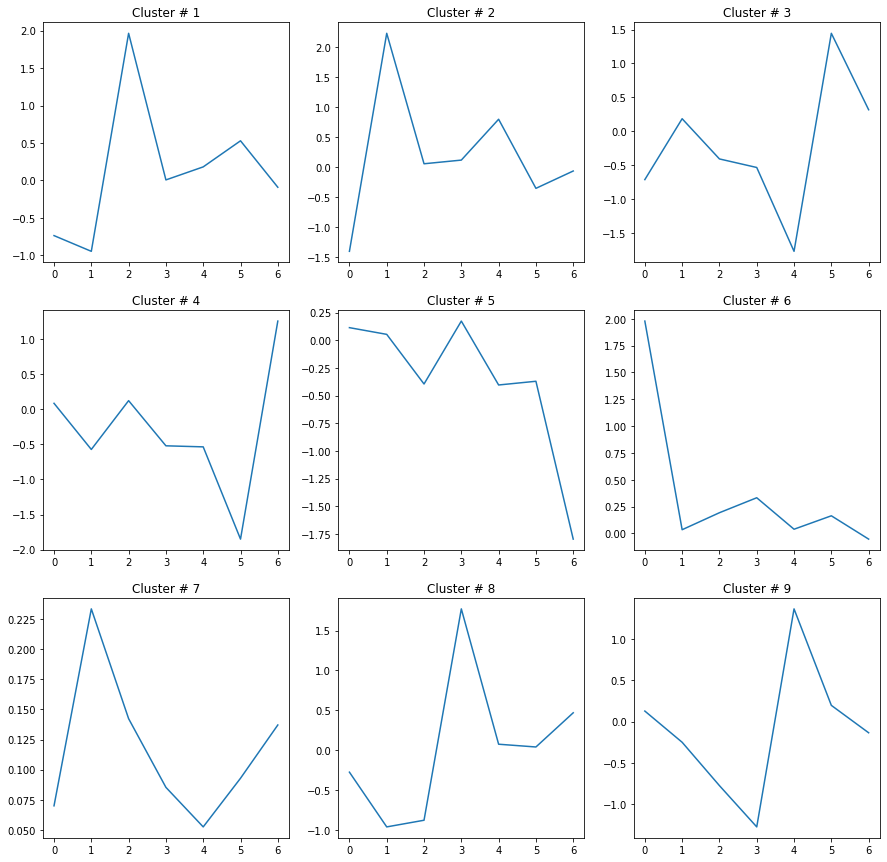

In [9]:
#Separated plots seems to be better

fig, axs = plt.subplots(3,3,figsize=(15, 15))
i = 1
for ax, cluster in zip(axs.flatten(),clusters.tolist()):
  ax.plot(cluster)
  ax.set_title(f'Cluster # {i}')
  i = i+1

In [10]:
df = pd.DataFrame(X_train,columns = list(range(1,8))) 
df["cluster"] = classifier.predict(X_train) #To classify each state
print(df.shape)
df.head()

(4624, 8)


,1,2,3,4,5,6,7,cluster
0,-3.834467,0.192218,0.095568,2.709040,1.118997,-1.306251,-0.438637,1
1,0.192218,0.095568,2.709040,1.118997,-1.306251,-0.438637,1.216970,0
2,0.095568,2.709040,1.118997,-1.306251,-0.438637,1.216970,1.067130,1
3,2.709040,1.118997,-1.306251,-0.438637,1.216970,1.067130,-0.683207,5
4,1.118997,-1.306251,-0.438637,1.216970,1.067130,-0.683207,0.052229,7


## Make markov chain and find the transition matrix

In [11]:
indx = list(range(0,4624,7))
new_df = df.iloc[indx] #

sequence = new_df.cluster.to_list()

markov_chain = {}

# Loop over the sequence and update the Markov chain
for i in range(len(sequence)-1):
    current_state = sequence[i]
    next_state = sequence[i+1]
    if current_state not in markov_chain:
        markov_chain[current_state] = [0 for i in range(0,9)]
    markov_chain[current_state][next_state] += 1


In [12]:
def get_transition_probs(markov_chain):
  transition_probs = {}
  for k in markov_chain:
    transition_probs[k] = markov_chain[k]/np.sum(markov_chain[k])

  return transition_probs

transition_probs = get_transition_probs(markov_chain)
transition_matrix = np.stack([transition_probs[i] for i in range(0,9)],axis=0)

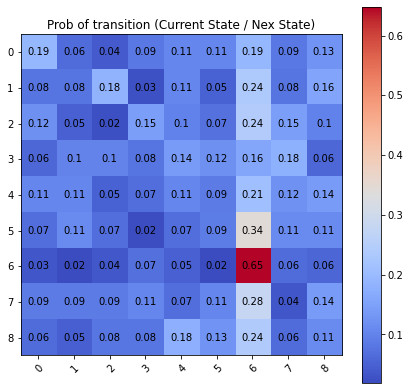

In [13]:
#@title HeatMatPlot Function 
labels = [str(i) for i in range(0,9)]

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(transition_matrix,cmap="coolwarm")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, round(transition_matrix[i, j],2),
                       ha="center", va="center", color="black")

ax.set_title("Prob of transition (Current State / Nex State)")
fig.tight_layout()
fig.colorbar(im, ax=ax)
plt.show()

Given the transition matrix, it appears that cluster 6 is the most frequented state, so it is considered important to study the pattern. It is also required further analysis and research to really take advantage of each cluster and possible transition.